# Goals: rebuild Random Forest Regression from scratch

Use only python and some basic numpy function (numpy slicing, np.mean, np.nonzero)

Produce comparable results to Sklearn Ramdon Forest on some regression dataset

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
from sklearn.tree import export_graphviz
import IPython,graphviz
import re
import matplotlib.pyplot as plt
np.random.seed(42)

In [4]:
# fast.ai fnc
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [5]:
class TreeBagging():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=3):
        np.random.seed(42)
        if hasattr(y,'values'): y = y.values
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # generate random idxs with size sample_sz
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTreeRegressor(self.x.iloc[rnd_idxs].values, self.y[rnd_idxs], min_leaf=self.min_leaf)        
    def predict(self, x):
        if hasattr(x,'values'): x = x.values
        return np.mean([t.predict(x) for t in self.trees], axis=0)
def var_agg(n,s,s_squared): return (s_squared/n) - (s/n)**2   

In [7]:
class DecisionTreeRegressor():
    def __init__(self, x, y, min_leaf=3):
        self.x,self.y,self.min_leaf = x,y,min_leaf        
        self.n,self.c = len(y), x.shape[1]
        if self.x.shape[0] != self.n:
            raise ValueError('x and y don\'t have the same size')            
        self.val = np.mean(y)
        
        # Metric (loss score)
        self.score = float('inf') # initialize to infinity for a leaf
        
        self.col_idx= -1 # index of column chosen to split
        self.split_value = None # chosen split value from col with col_idx
        
        self.lhs_tree = None
        self.rhs_tree = None
        
        self.find_varsplit()

        
    def find_varsplit(self):
        # Assuming max_feature = self.c, as we consider all features for splitting
        for i in range(self.c): self.find_better_split(i)
        if self.is_leaf: return
        x= self.split_col
        lhs_idx = np.nonzero(x<=self.split_value)[0]
        rhs_idx = np.nonzero(x>self.split_value)[0]
        
        self.lhs_tree = DecisionTreeRegressor(self.x[lhs_idx,:], self.y[lhs_idx])
        self.rhs_tree = DecisionTreeRegressor(self.x[rhs_idx,:], self.y[rhs_idx])

    def find_better_split(self, col_idx): 
        x = self.x[:,col_idx]
        y = self.y

        sort_idx = np.argsort(x)
        sort_x,sort_y = x[sort_idx],y[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n,sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2=0,0.0,0.0
        for i in range(0,self.n- self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]: # cannot split at a duplicate. ALl dups should be in 1 side
                continue
            
            # the idea is to find the split with LOWEST VARIANCE. Variance (ddof = 0) is equivalent to MSE score against mean
            # That means standard Deviation is equivalent to RMSE score against mean
            lhs_var = var_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_var = var_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = (lhs_var*lhs_cnt + rhs_var*rhs_cnt) # equivalent to MSE score in comparison
            if curr_score<self.score: 
                self.col_idx,self.score,self.split_value = col_idx,curr_score,xi
    
    
    @property
    def split_col(self): 
        return self.x[:,self.col_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    #prediction
    def predict(self,x):
        return np.array([self.predict_row(xi) for xi in x])
    def predict_row(self,xi):
        if self.is_leaf: return self.val
        subtree = self.lhs_tree if xi[self.col_idx]<=self.split_value else self.rhs_tree
        return subtree.predict_row(xi)
    
    def __repr__(self):
        mse = metrics.mean_squared_error(self.y, [self.val]*self.n)
        s = f'Sample size: {self.n}. Pred value: {self.val:0.2f}. MSE: {mse:0.2f}\n'
        if not self.is_leaf:
            s += f'Best split from feature {self.col_idx} at value {self.split_value}.  Best split\'s MSE Score:{self.score:0.2f}'
        return s

# Generate a fake dataset

In [8]:
nrows=20
df = pd.DataFrame(np.random.randint(1,10,(nrows,3)),columns=list('aby'))
print(df.head())
y = df.y.values
df.drop('y',axis=1,inplace=True)

   a  b  y
0  7  4  8
1  5  7  3
2  7  8  5
3  4  8  8
4  3  6  5


# Check whether my RF splits are valid against sklearn's Random Forest

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

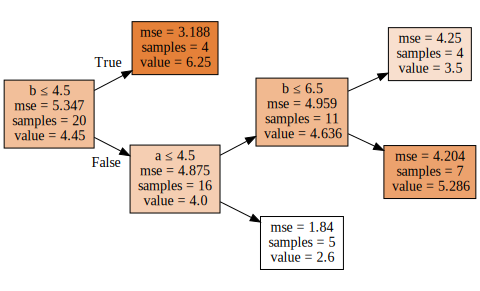

In [9]:
# sklearn RF split
rf = RandomForestRegressor(n_estimators=1,max_depth=3,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)
draw_tree(rf.estimators_[0], df, precision=3)

In [10]:
# My RF split
ens = TreeBagging(df, y, 1, nrows)
tree = ens.trees[0]
tree

Sample size: 20. Pred value: 4.45. MSE: 5.35
Best split from feature 1 at value 4.  Best split's MSE Score:90.75

In [11]:
tree.lhs_tree

Sample size: 4. Pred value: 6.25. MSE: 3.19

In [12]:
tree.rhs_tree

Sample size: 16. Pred value: 4.00. MSE: 4.88
Best split from feature 0 at value 4.  Best split's MSE Score:63.75

In [13]:
print(tree.lhs_tree.lhs_tree)
print(tree.lhs_tree.rhs_tree)

None
None


In [14]:
print(tree.rhs_tree.lhs_tree)
print(tree.rhs_tree.rhs_tree)

Sample size: 11. Pred value: 4.64. MSE: 4.96
Best split from feature 1 at value 6.  Best split's MSE Score:46.43
Sample size: 5. Pred value: 2.60. MSE: 1.84



'Scratch' RF regressor is able to produce the exact split like sklearn RF

# Benchmarking on fake dataset

In [15]:
nrows=1000
ncols=10
df = pd.DataFrame(np.random.randint(1,10,(nrows,ncols)))
y = df[ncols-1].values
df.drop(ncols-1,axis=1,inplace=True)

In [16]:
rf = RandomForestRegressor(n_estimators=5,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)

rf_pred = rf.predict(df)
print(f'MSE score: {metrics.mean_squared_error(y,rf_pred)}')
print(f'R2 score: {metrics.r2_score(y,rf_pred)}')

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

MSE score: 1.6711164888888888
R2 score: 0.7621670960849272


In [17]:
tb = TreeBagging(df, y, n_trees=5, sample_sz=nrows)
tb_pred = tb.predict(df)
print(f'MSE score: {metrics.mean_squared_error(y,tb_pred)}')
print(f'R2 score: {metrics.r2_score(y,tb_pred)}')

MSE score: 1.72175
R2 score: 0.7549609467452253


# Benchmarking: Boston housing dataset

The dataset for this project originates from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:

- 16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
- 1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
- The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.
- The feature 'MEDV' has been multiplicatively scaled to account for 35 years of market inflation.

In [18]:
housing = pd.read_csv('data/housing.csv')
print(housing.shape)
housing.head()

(489, 4)


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [19]:
y = housing.MEDV.values
X = housing.drop('MEDV',axis=1)

In [20]:
from sklearn.model_selection import train_test_split
def get_train_val(X,y):
    X_train,X_val,y_train,y_val =  train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train.reset_index(drop=True),X_val.reset_index(drop=True),y_train,y_val

In [21]:
X_train,X_val,y_train,y_val = get_train_val(X,y)

### sklearn Random Forest

In [22]:
# rf = RandomForestRegressor(n_estimators=10,bootstrap=False,min_samples_leaf=10)
rf = RandomForestRegressor(n_estimators=10,max_depth=5,bootstrap=False,min_samples_leaf=5)
rf.fit(X_train,y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

print(f'MSE train score: {metrics.mean_squared_error(y_train,rf_train_pred)}')
print(f'MSE val score: {metrics.mean_squared_error(y_val,rf_val_pred)}')
print(f'R2 train score: {metrics.r2_score(y_train,rf_train_pred)}')
print(f'R2 val score: {metrics.r2_score(y_val,rf_val_pred)}')

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

MSE train score: 3260533106.403395
MSE val score: 3375622350.4114494
R2 train score: 0.8849351905000116
R2 val score: 0.8464062312034625


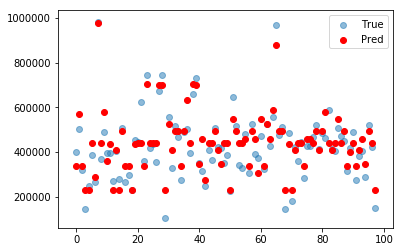

In [23]:
plt.scatter(range(0,len(y_val)),y_val,alpha=0.5,label='True')
plt.scatter(range(0,len(rf_val_pred)),rf_val_pred,c='r',label='Pred')
plt.legend()
plt.show()

## My Random Forest

In [24]:
X_train,X_val,y_train,y_val = get_train_val(X,y)

In [25]:
X_train.shape[0]

391

One possible thing I can tune here but not in sklearn Random Forest is the size of data subset for each tree (sample_sz)

In [26]:
%%time
tb = TreeBagging(X_train, y_train, n_trees=50, sample_sz=120,min_leaf=5)

CPU times: user 322 ms, sys: 0 ns, total: 322 ms
Wall time: 322 ms


In [27]:
tb_train_pred = tb.predict(X_train)
tb_val_pred = tb.predict(X_val)
print(f'MSE train score: {metrics.mean_squared_error(y_train,tb_train_pred)}')
print(f'MSE val score: {metrics.mean_squared_error(y_val,tb_val_pred)}')
print(f'R2 train score: {metrics.r2_score(y_train,tb_train_pred)}')
print(f'R2 val score: {metrics.r2_score(y_val,tb_val_pred)}')

MSE train score: 3372980847.6148586
MSE val score: 3414049544.1749997
R2 train score: 0.8809668891520539
R2 val score: 0.8446577602841077


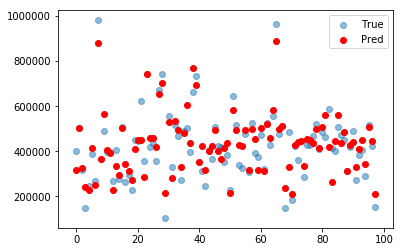

In [28]:
plt.scatter(range(0,len(y_val)),y_val,alpha=0.5,label='True')
plt.scatter(range(0,len(tb_val_pred)),tb_val_pred,c='r',label='Pred')
plt.legend()
plt.show()

Able to draw a comparable result to sklearn Random Forest

In [29]:
# Take a look at prediction differences b/t 2 models
pd.Series(abs(rf_val_pred-tb_val_pred)).describe()

count        98.000000
mean      22198.563941
std       26558.338376
min          26.600000
25%        5491.794512
50%       12963.300000
75%       25482.058209
max      143747.800000
dtype: float64

# Calculate feature importance

Feature importance will be calculated by using **permutation importance**. There is an argument which is mentioned in this [doc](http://parrt.cs.usfca.edu/doc/rf-importance/index.html#3) that feature importance calculated in sklearn is misleading. SKlearn used **mean decrease in impurity (gini improtance)**, which does not always give an accurate picture of importance. 

On the other hand, **permutation importance** is calculated as follows: Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. This is more expensive to calculate, but results are more reliable

In [33]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict(X_val)

    return metrics.r2_score(y_val,y_val_pred)

def permutation_importances(rf,X_val,y_val,metric):
    baseline = metric(rf,X_val,y_val)
    imp=[]
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = metric(rf,X_val,y_val)
        X_val[col] = save
        imp.append(baseline-m)
    return np.array(imp)

## Feature importance from Sklearn's RF model


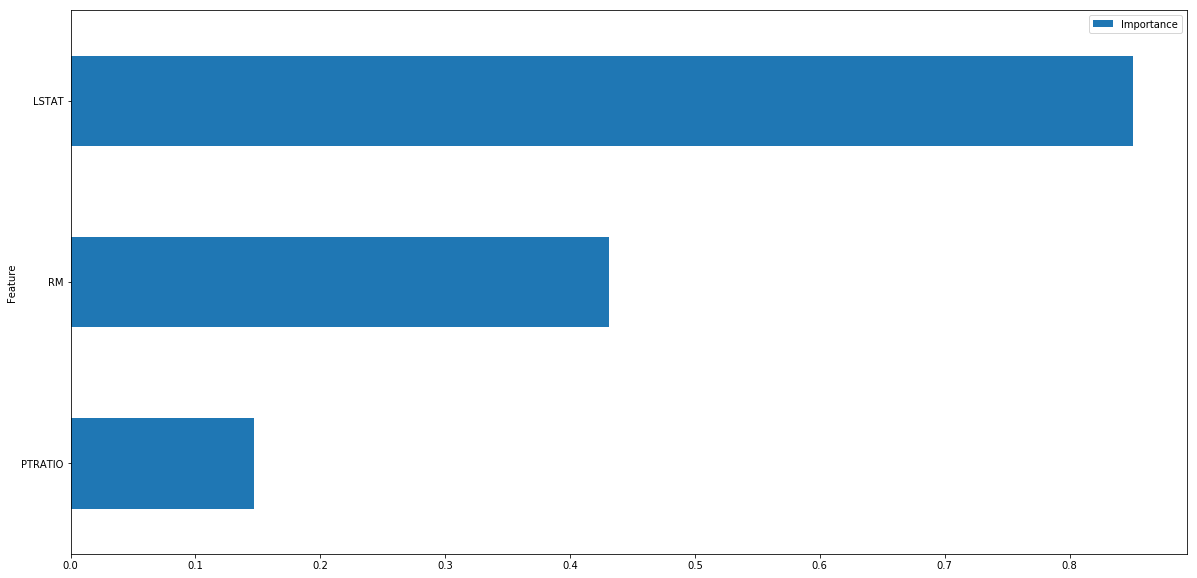

In [34]:

fea_imp = permutation_importances(rf,X_val,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':X_val.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))

## Feature importance from 'scratch' RF

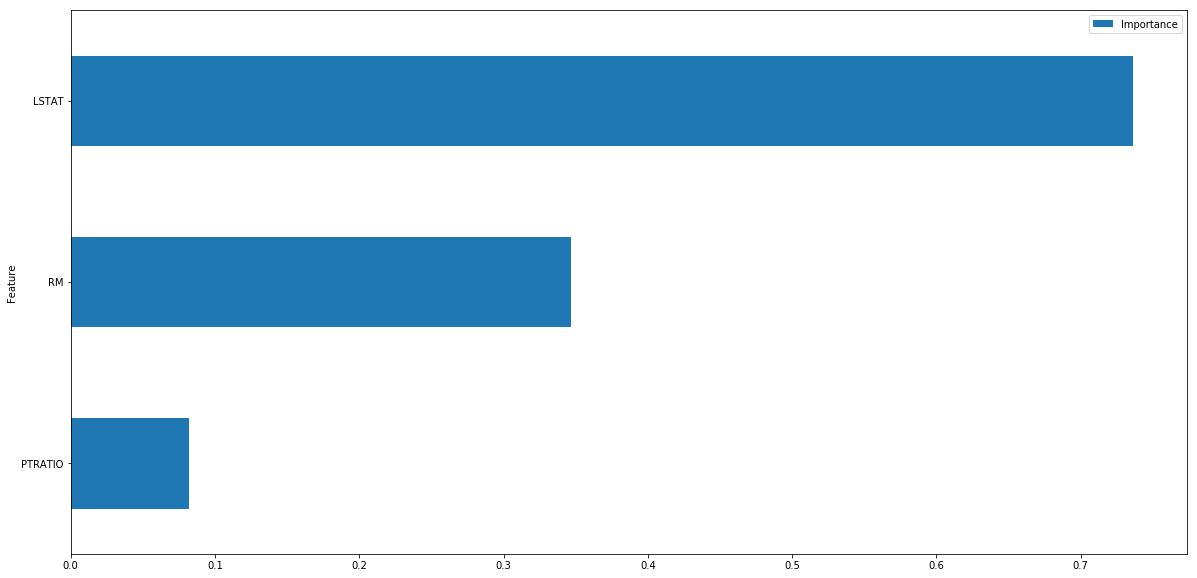

In [35]:
fea_imp = permutation_importances(tb,X_val,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':X_val.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))